<a href="https://colab.research.google.com/github/Fortuna3Co/University-field-training/blob/main/tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

from bokeh.plotting import figure, show, output_notebook, output_file, save
from bokeh.models import LinearAxis, Range1d, ColumnDataSource, HoverTool
from bokeh.embed import file_html
from bokeh.layouts import row, gridplot
from bokeh.palettes import Spectral11 as palette
from bokeh.io import curdoc
from scipy.optimize import curve_fit

output_notebook()

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def find_file_and_get_raw_datas(folder_path, file_extension):
  # 폴더 안 파일을 file_list에 저장
  file_list = os.listdir(folder_path)

  # file_list 중 file_extension으로 지정해준 확장자인 것만 all_file_list에 저장
  all_file_list = []
  for file in file_list:
    if file.endswith(file_extension):
      all_file_list.append(file)

  # all_file_list 정렬
  all_file_list = sorted(all_file_list)
  
  # all_file_list로 해당 파일 정보 df 형태로 가져온 후 리스트에 저장해 반환
  log_datas = []
  for file in all_file_list:
    log_datas.append(pd.read_csv(folder_path + "/" + file, sep=',', encoding="cp949"))
  return log_datas
  

# Data post processing



In [ ]:
df_datas = pd.read_csv("/content/drive/MyDrive/Robostar/Model_Fitting_data/J1_Friction_Law.csv")
def data_post_processing(log_datas):
  
  TINY = 1e-6
  results = []

  for x in range(len(log_datas)):
    df_datas = log_datas[x]

    # Remove Section Zero
    modified_df = df_datas[df_datas["section_block"] != 0]
    modified_df = modified_df.reset_index(drop=True)

    # Calculate Friction Torque
    for i in range(6):
      modified_df["trq_fric" + str(i+1)] = modified_df["motor_trq" + str(i+1)] - modified_df["cal_trq" + str(i+1)]

    # Find Constant Speed
    modified_df["joint_acc_ref" + str(x + 1)] = modified_df["joint_vel_ref" + str(x + 1)].diff() / 0.002
    modified_df = modified_df[np.abs(modified_df['joint_acc_ref' + str(x + 1)]) < TINY]
    modified_df = modified_df.reset_index(drop=True)

    # Delete Velocity zero
    modified_df = modified_df[np.abs(modified_df["joint_vel_ref" + str(x + 1)]) > TINY]     # joint_vel_ref1
    modified_df = modified_df.reset_index(drop=True)

    # Average Torque
    vel, ave_fric = [], []
    for i in range(1, max(modified_df['section_block'])):
      section_df = modified_df[modified_df['section_block'] == i]
      section_df = section_df[:][len(section_df)//3:-len(section_df)//3]
      vel.append(section_df.iloc[0]['joint_vel_ref' + str(x + 1)])
      ave_fric.append(section_df['trq_fric' + str(x + 1)].mean())

    data = {'vel': vel, 'ave_fric': ave_fric}
    result_df = pd.DataFrame(data)
    result_df = result_df.sort_values(by='vel')

    result_df.reset_index(drop=True, inplace=True)
    results.append(result_df)
  return results

# CTO Model Function

In [ ]:
def func(x, a1, a2, a3, a4, r):
  'a1*vel + a2*vel**3 + a3*tanh(r*vel) + a4*((r*x)/(0.005+abs(r*x)))'
  return a1 * x + a2 * x ** 3 + a3 * np.tanh(r*x) + a4*((r*x)/(0.0005+abs(r*x)))

# Model Fitting & Result

In [ ]:
def model_fitting(processing_results):
  popt_pcov_list = []
  
  results = []
  for i in range(len(processing_results)):
    x = np.array(processing_results[i]["vel"].values)
    y = np.array(processing_results[i]["ave_fric"].values)

    popt, pcov = curve_fit(func, x, y)

    modelPredictions = func(x, *popt)
    absError = modelPredictions - y
    SE = np.square(absError)
    MSE = np.mean(SE)
    RMSE = np.sqrt(MSE)
    Rsquared = 1.0 - (np.var(absError) / np.var(y))

    #print('Parameters:', popt)
    #print('RMSE:', RMSE)
    #print('R-squared:', Rsquared)

    result = {'x' : x, 'y': y, 'popt' : popt}

    results.append(result)
  return results

# Graph

In [ ]:
def start():
  folder_path = "/content/drive/MyDrive/Robostar/Model_Fitting_data"

  df_datas = find_file_and_get_raw_datas(folder_path, '.csv')
  processing_results = data_post_processing(df_datas)
  fitting_results = model_fitting(processing_results)

  plots = []
  for i in range(len(fitting_results)):
    curdoc().theme = "caliber"
    TOOLS = "pan, wheel_zoom, box_select, lasso_select, reset, save, hover"
    TOOLTIPS = [
      ("index", "$x"),
      ("y_value", "$y)"),
    ]
    # x : fitting_results[i]['x'], y : fitting_results[i]['y'] or func(fitting_results[i]['x'], *fitting_results[i]["popt"])
    p1 = figure(title="J" + str(i + 1), x_axis_label="vel (deg/s)", y_axis_label="torque(N/m)", plot_width=1200, plot_height=900, tools=TOOLS, tooltips=TOOLTIPS)

    p1.line(x = fitting_results[i]['x'], y = func(fitting_results[i]['x'], *fitting_results[i]["popt"]), color = palette[0], legend_label = 'Model', line_width = 5, line_alpha = 0.3)
    p1.scatter(x = fitting_results[i]['x'], y = fitting_results[i]['y'], legend_label = 'Data', marker = 'o', color = palette[-1], fill_color=palette[-1])

    p1.legend.location = "top_right"
    p1.legend.click_policy = "hide"
    p1.background_fill_color="#f0f0f0"
    p1.grid.grid_line_color="#f5f5f5"
    plots.append(p1)

  plot = gridplot(plots, ncols=3, toolbar_location="right", plot_width=400, plot_height=300)
  show(plot)
  #output_file(folder_path + "/" + "results_graph" + '.html')
  #save(plot)

  fw = open(folder_path + "/" + "results_popt.txt", 'w')
  for i in range(len(fitting_results)): # popt 저장
    popt_str = ""
    fw.write("<J" + str(i + 1) + ">\n")
    for popt in fitting_results[i]["popt"]:
      popt_str += str(popt)  + ","
    fw.write(popt_str[:-1] + "\n")
  fw.close()
    
start()

/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def norm(x):
  return (x - train_stats["mean"] / train_stats["std"])

def tensorflow_start():
  folder_path = "/content/drive/MyDrive/Robostar/Model_Fitting_data"

  df_datas = find_file_and_get_raw_datas(folder_path, '.csv')
  processing_results = data_post_processing(df_datas)
  fitting_results = model_fitting(processing_results)

  # print(fitting_results)

  X, y = fitting_results[0]['x'], fitting_results[0]['y']
  train_dataset = dataset.sample(frac=0.8, random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
  normed_train_data = norm(train_dataset)

  model.summary()

  curdoc().theme = "caliber"
  TOOLS = "pan, wheel_zoom, box_select, lasso_select, reset, save, hover"
  TOOLTIPS = [
      ("index", "$x"),
      ("y_value", "$y)"),
  ]  
  
  p1 = figure(title="J" + str(1), x_axis_label="vel (deg/s)", y_axis_label="torque(N/m)", plot_width=400, plot_height=300, tools=TOOLS, tooltips=TOOLTIPS)
  p1.line(x = fitting_results[0]['x'], y = preds, color = palette[0], legend_label = 'Model', line_width = 5, line_alpha = 0.3)
  p1.scatter(x = fitting_results[0]['x'], y = fitting_results[0]['y'], legend_label = 'Data', marker = 'o', color = palette[-1], fill_color=palette[-1])
  show(p1)

In [ ]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

folder_path = "/content/drive/MyDrive/Robostar/Model_Fitting_data"

df_datas = find_file_and_get_raw_datas(folder_path, '.csv')
processing_results = data_post_processing(df_datas)
fitting_results = model_fitting(processing_results)


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [ ]:
fitting_results[0]
dataset = pd.DataFrame()
dataset['x'] = fitting_results[0]['x']
dataset['y'] = fitting_results[0]['y']

dataset.tail()

,x,y
212,285.0000,-20.113924
213,288.0000,-19.792405
214,291.0000,-20.102532
215,294.0000,-20.169620
216,296.2594,-20.215190


In [ ]:
dataset.isna().sum()

x    0
y    0
dtype: int64

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

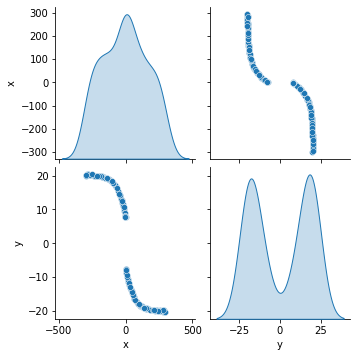

In [ ]:
sns.pairplot(train_dataset[['x', 'y']], diag_kind="kde")

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('y')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
x,174.0,-6.439202,167.182527,-300.0,-143.181825,-0.44985,122.019975,296.2594


In [ ]:
train_labels = train_dataset.pop('y')
test_labels = test_dataset.pop('y')

In [ ]:
def norm(x):
  return (x - train_stats["mean"]) / train_stats["std"]

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

print(normed_test_data)

            x
9   -1.593618
21  -1.377203
25  -1.305064
29  -1.232925
31  -1.196857
32  -1.178822
36  -1.109568
39  -1.055327
47  -0.910687
58  -0.713701
67  -0.553560
70  -0.498907
72  -0.463746
77  -0.373474
79  -0.337813
81  -0.301969
82  -0.284392
87  -0.194529
88  -0.176444
99   0.020587
103  0.027749
115  0.051077
117  0.054653
127  0.217961
140  0.451239
142  0.487127
147  0.576850
148  0.594794
165  0.899850
167  0.935739
172  1.025461
174  1.058800
175  1.079295
177  1.115184
178  1.133128
182  1.201997
191  1.363095
192  1.384350
193  1.402295
195  1.434694
204  1.599684
206  1.631590
209  1.689406


In [ ]:
def build_model():
  model = keras.Sequential([
                            layers.Dense(64, activation="relu", input_shape=[len(train_dataset.keys())]),
                            layers.Dense(64, activation="relu"),
                            layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss="mse", optimizer=optimizer, metrics=["mae", "mse"])
  return model

In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 65        
Total params: 4,353
Trainable params: 4,353
Non-trainable params: 0
_________________________________________________________________


In [ ]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1517596 ],
       [-0.15714169],
       [-0.08224845],
       [-0.09805392],
       [-0.00239974],
       [-0.05640534],
       [-0.00220525],
       [-0.0127373 ],
       [-0.23981921],
       [-0.05373105]], dtype=float32)

In [ ]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')


In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()



....................................................................................................
....................................................................................................
....................................................................................................
...............................................................................................

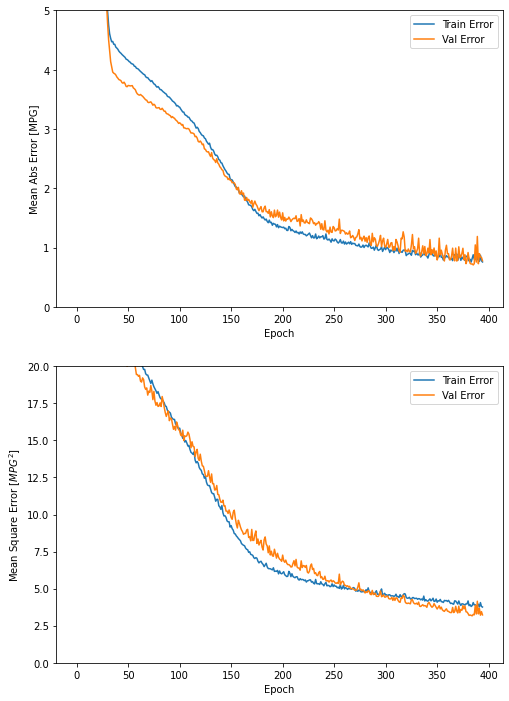

In [ ]:
model = build_model()
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
EPOCHS=5000
history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split=0.2, verbose=0, callbacks=[early_stop, PrintDot()]
)
plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("테스트 세트의 평균 절대 오차: {:5.2f} MPG".format(mae))

2/2 - 0s - loss: 2.5583 - mae: 0.7343 - mse: 2.5583
테스트 세트의 평균 절대 오차:  0.73 MPG


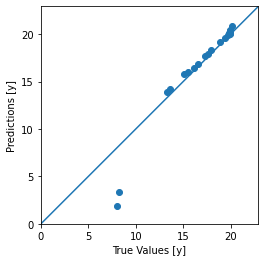

In [ ]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [y]')
plt.ylabel('Predictions [y]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

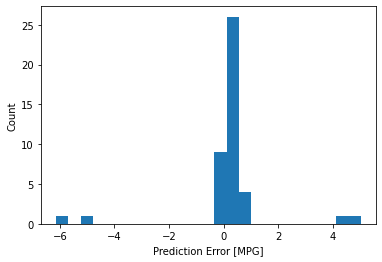

In [ ]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

ValueError: ignored

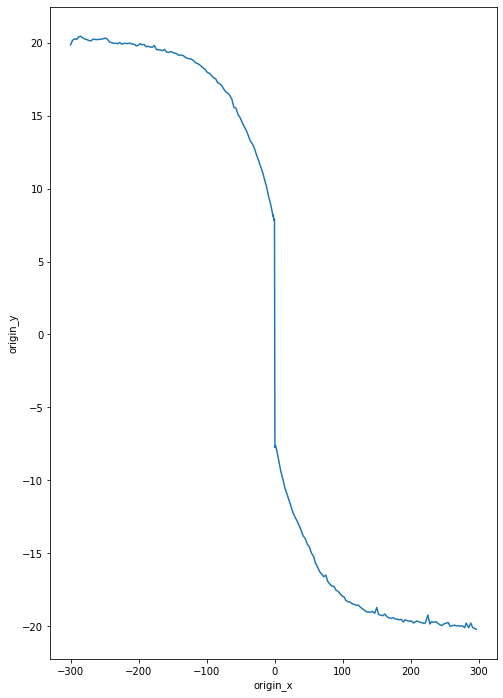

In [ ]:
def plot_prediction(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(2,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(2,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

plt.figure(figsize=(8, 12))
plt.xlabel('origin_x')
plt.ylabel('origin_y')
plt.plot(fitting_results[0]['x'], fitting_results[0]['y'], label='orgin')

predicition = model.predict(normed_x).flatten()
plt.plot(fitting_results[0]['x'], predicition, label='predicit')

In [ ]:
df = pd.DataFrame()

list_x, list_y = [], []
for i in range(0, len(fitting_results)):
  for j in range(0, len(fitting_results[i]['x'])):
    list_x.append(fitting_results[i]['x'][j])
    list_y.append(fitting_results[i]['y'][j])
print(list_x)
df_x['x'], df_y['y'] = pd.DataFrame(list_x), pd.DataFrame(list_y)
df['x'], df['y'] = df_x['x'], df_y['y']

df
